# Music Information Retrieval
### 1. Music Feature Retrieval

In [1]:
import pandas as pd
import numpy as np
import librosa
import os

def mir(music_file):
    # Load the audio file
    y, sr = librosa.load(music_file, sr=None)

    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # MFCCs
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral contrast
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)  # Zero-crossing rate
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)  # Tempo
    rms = librosa.feature.rms(y=y)  # Root Mean Square (RMS) energy
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral centroid
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Spectral bandwidth
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)  # Spectral rolloff
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)  # Tonal centroid features
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)  # Constant-Q chroma
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)  # Chroma Energy Normalized (CENS)

    # Aggregation function
    def aggregate(feature_matrix):
        return np.concatenate([np.mean(feature_matrix, axis=1), 
                              np.std(feature_matrix, axis=1)])

    # Combine all features into a single array
    features = np.concatenate([
        aggregate(mfccs),
        aggregate(chroma_stft),
        aggregate(spectral_contrast),
        aggregate(zero_crossing_rate),
        aggregate(np.array([tempo]).reshape(-1, 1)),  # Reshape tempo to 2D
        aggregate(rms),
        aggregate(spectral_centroid),
        aggregate(spectral_bandwidth),
        aggregate(spectral_rolloff),
        aggregate(tonnetz),
        aggregate(chroma_cqt),
        aggregate(chroma_cens)
    ])

    return features

features_list = []
valence_list = []
arousal_list = []
music_name_list = []
music_file_name = 0

print("Starting to extract features...")

train_label_deam = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\DEAM\static_annotations_averaged_songs_1_2000.csv")
train_label_pmemo = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\PMEmo\static_annotations.csv")
test_label_deam = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\DEAM\static_annotations_averaged_songs_2000_2058.csv")

while music_file_name <= 2058:
    music_path = os.path.join(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\DEAM\audios", str(music_file_name) + ".mp3")
    if os.path.exists(music_path): 
        features = mir(music_path)
        
        # Append features and label to the lists
        features_list.append(features)
        music_name_list.append(music_file_name)
        # Extract valence and arousal values from a csv file of the song_id corresponding to the music
        if music_file_name <= 2000:
            valence_list.append(train_label_deam[train_label_deam['song_id'] == music_file_name][' valence_mean'].values[0]) 
            arousal_list.append(train_label_deam[train_label_deam['song_id'] == music_file_name][' arousal_mean'].values[0]) 
        else:
            valence_list.append(test_label_deam[test_label_deam['song_id'] == music_file_name][' valence_mean'].values[0])
            arousal_list.append(test_label_deam[test_label_deam['song_id'] == music_file_name][' arousal_mean'].values[0]) 
        music_file_name += 1
    else:
        music_file_name += 1
        
for music_file_name in os.listdir(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\PMEmo\chorus"):
    music_path = os.path.join(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_data\PMEmo\chorus", music_file_name)
    if os.path.exists(music_path): 
        features = mir(music_path)
        
        # Append features and label to the lists
        features_list.append(features)
        
        # To prevent from overwriting the music_file_name with DEAM files, add a prefix
        music_file_name = music_file_name.replace(".mp3", "")
        music_file_name = int(music_file_name)
        
        # Extract valence and arousal values from a csv file of the song_id corresponding to the music
        valence_row = train_label_pmemo[train_label_pmemo['musicId'] == music_file_name]
        if not valence_row.empty:
            music_file_name = str(music_file_name)
            music_file_name = "PMEmo_" + music_file_name
            music_name_list.append(music_file_name)
            valence_list.append(valence_row['Valence(mean)'].values[0])
            arousal_list.append(valence_row['Arousal(mean)'].values[0])
        else:
            continue
        
# Convert lists to numpy arrays
features_array = np.array(features_list)
valence_array = np.array(valence_list)
arousal_array = np.array(arousal_list)
music_name_array = np.array(music_name_list)

# Create a DataFrame
df = pd.DataFrame(music_name_array, columns=['Music_Name'])
df['Valence'] = valence_array
df['Arousal'] = arousal_array

columns = []
for i in range(13):
    columns.append(f'mfcc_dct{i}_mean')
    columns.append(f'mfcc_dct{i}_std')
for i in range(12):
    columns.append(f'chroma_stft_chord{i}_mean')
    columns.append(f'chroma_stft_chord{i}_std')
for i in range(7):
    columns.append(f'spectral_contrast_frequency{i}_mean')
    columns.append(f'spectral_contrast_frequency{i}_std')
for i in range(1):
    columns.append(f'zero_crossing_rate_frame{i}_mean')
    columns.append(f'zero_crossing_rate_frame{i}_std')
columns.append('tempo_mean')
columns.append('tempo_std')
columns.append('rms_mean')
columns.append('rms_std')
columns.append('spectral_centroid_mean')
columns.append('spectral_centroid_std')
columns.append('spectral_bandwidth_mean')
columns.append('spectral_bandwidth_std')
columns.append('spectral_rolloff_mean')
columns.append('spectral_rolloff_std')
for i in range(6):
    columns.append(f'tonnetz_dim{i}_mean')
    columns.append(f'tonnetz_dim{i}_std')
for i in range(12):
    columns.append(f'chroma_cqt_chord{i}_mean')
    columns.append(f'chroma_cqt_chord{i}_std')
for i in range(12):
    columns.append(f'chroma_cens_chord{i}_mean')
    columns.append(f'chroma_cens_chord{i}_std')

df = df.join(pd.DataFrame(features_array, columns=columns))

print("Feature extraction completed.")
print(df.head())
print(df.shape)  # Output: (number_of_songs, number_of_features)

# Save the DataFrame to a CSV file
df.to_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_train_dataset.csv", index=False)

Starting to extract features...
Feature extraction completed.
  Music_Name  Valence  Arousal  mfcc_dct0_mean  mfcc_dct0_std  mfcc_dct1_mean  \
0          2      3.1      3.0     -200.259857     171.772614      -32.708050   
1          3      3.5      3.3     -285.926178     159.132568        7.611665   
2          4      5.7      5.5     -163.723801     166.300110      -29.482483   
3          5      4.4      5.3     -190.341141     162.434845      -10.739488   
4          7      5.8      6.4     -208.911133     156.988312       -2.480501   

   mfcc_dct1_std  mfcc_dct2_mean  mfcc_dct2_std  mfcc_dct3_mean  ...  \
0      36.403446        0.236144      17.683105        1.365153  ...   
1      33.757629       25.207741      20.010067       18.247145  ...   
2      36.676277       10.505774      39.914688       -2.767269  ...   
3      38.936256       -6.951975      10.322243      -25.887856  ...   
4      62.610767       13.259298      27.919954       20.397331  ...   

   chroma_cens_cho

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_train_dataset.csv", index=False)

### 2. Preparing Datasets

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
music_df = pd.read_csv(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_train_dataset.csv")

train_df, test_df = train_test_split(music_df, test_size=0.2, random_state=42)
X_train = train_df.iloc[:, 3:] # Exclude the first three columns (Music_Name, Valence, Arousal)
y_train = train_df[['Valence', 'Arousal']]
X_test = test_df.iloc[:, 3:]
y_test = test_df[['Valence', 'Arousal']]


print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_test.shape}, {y_test.shape}")
print(f"Column names: {X_train.columns}")


Training set shape: (2055, 136), (2055, 2)
Validation set shape: (514, 136), (514, 2)
Column names: Index(['mfcc_dct0_mean', 'mfcc_dct0_std', 'mfcc_dct1_mean', 'mfcc_dct1_std',
       'mfcc_dct2_mean', 'mfcc_dct2_std', 'mfcc_dct3_mean', 'mfcc_dct3_std',
       'mfcc_dct4_mean', 'mfcc_dct4_std',
       ...
       'chroma_cens_chord7_mean', 'chroma_cens_chord7_std',
       'chroma_cens_chord8_mean', 'chroma_cens_chord8_std',
       'chroma_cens_chord9_mean', 'chroma_cens_chord9_std',
       'chroma_cens_chord10_mean', 'chroma_cens_chord10_std',
       'chroma_cens_chord11_mean', 'chroma_cens_chord11_std'],
      dtype='object', length=136)


### 3. Train the Random Forest

In [4]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from joblib import dump

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10, step=1)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Create the model with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Run the Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    random_state=42
)
final_model.fit(X_train, y_train)

# Save the trained model to a file
dump(final_model, r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\music_model_optimized.joblib")
print("Optimized model saved successfully!")

c:\Users\cxoox\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-10 20:56:35,706] A new study created in memory with name: no-name-2312a95b-21c2-4c18-8fe8-ed5b9a64cd67
[I 2025-05-10 20:57:24,088] Trial 0 finished with value: 1.8538088054266761 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 1.8538088054266761.
[I 2025-05-10 20:57:33,851] Trial 1 finished with value: 1.9943941789751065 and parameters: {'n_estimators': 800, 'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 1.8538088054266761.
[I 2025-05-10 20:59:36,702] Trial 2 finished with value: 1.8169315774916992 and parameters: {'n_estimators

Best hyperparameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}
Optimized model saved successfully!


In [5]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Predict on the test set
y_pred = final_model.predict(X_test)

# Constrain the predictions to the range [1, 9]
y_pred = np.clip(y_pred, 1, 9)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Print evaluation results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 Score:", r2)
print("Explained Variance Score:", explained_variance)

Mean Squared Error (MSE): 1.812415508138173
Mean Absolute Error (MAE): 0.9608781390552361
Root Mean Squared Error (RMSE): 1.346259821928209
R^2 Score: 0.6085577070954613
Explained Variance Score: 0.6087844800148897


In [6]:
features = mir(r"C:\Users\cxoox\Downloads\ashes-of-hiroshima-272353.mp3")
features = np.array(features).reshape(1, -1)

# Predict and constrain the predictions to the range [1, 9]
predicted_valence, predicted_arousal = np.clip(final_model.predict(features)[0], 1, 9)
print(f"Predicted Valence: {predicted_valence}, Predicted Arousal: {predicted_arousal}")

NameError: name 'mir' is not defined

### 4. Result Plotting

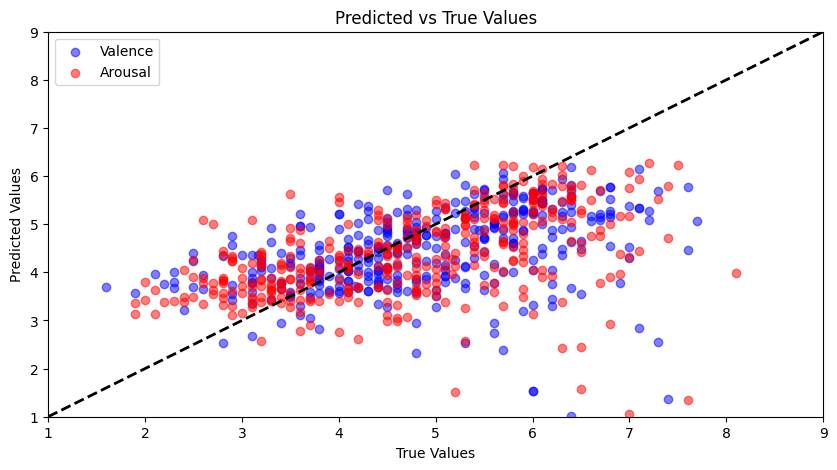

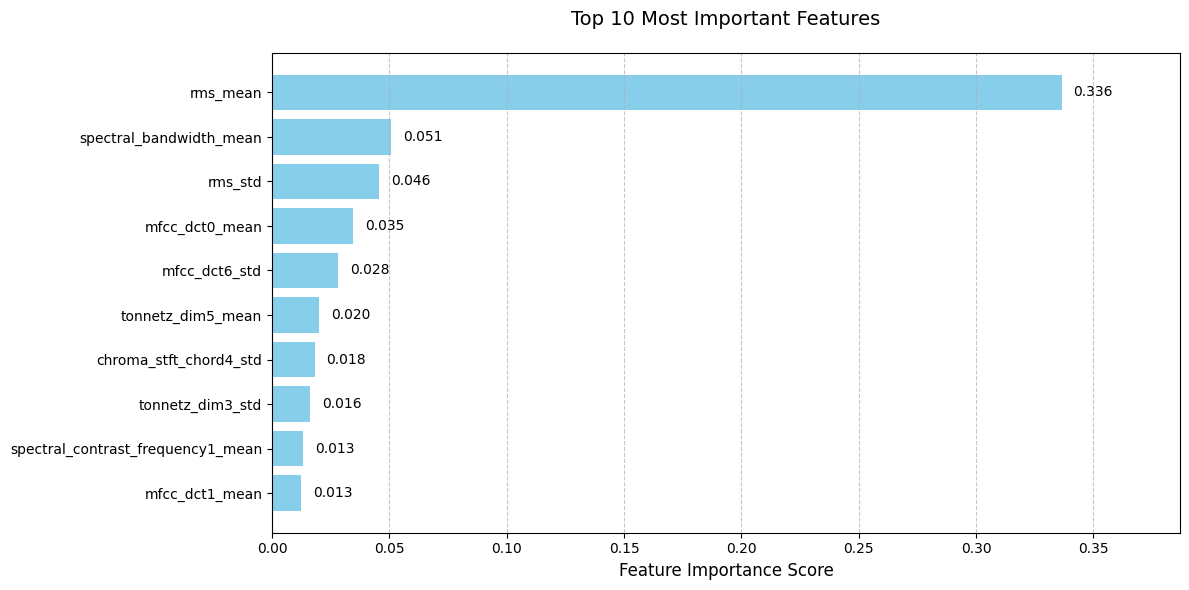

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Constrain the predictions on the test set to the range [1, 9]
y_pred = np.clip(y_pred, 1, 9)

# Plotting the results, on the scale of 1 to 9
plt.figure(figsize=(10, 5))
plt.scatter(y_test['Valence'], y_pred[:, 0], label='Valence', color='blue', alpha=0.5)
plt.scatter(y_test['Arousal'], y_pred[:, 1], label='Arousal', color='red', alpha=0.5)
plt.plot([1, 9], [1, 9], 'k--', lw=2)  # Diagonal line
plt.xlim(1, 9)
plt.ylim(1, 9)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.legend()
plt.savefig(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\predicted_vs_true_values.svg", dpi=300, bbox_inches='tight')
plt.show()

# Get feature importance and sort
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order
sorted_features = X_train.columns[indices]

# Extract the top 10 features
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = sorted_features[:top_n]

# Plot a horizontal bar chart (easier to read)
plt.figure(figsize=(12, 6))
plt.title("Top 10 Most Important Features", fontsize=14, pad=20)
bars = plt.barh(top_feature_names, top_importances, align='center', color='skyblue')

# Add importance score labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005,  # Offset to avoid overlap
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             va='center',
             fontsize=10)

# Beautify the chart
plt.gca().invert_yaxis()  # Display importance from high to low
plt.xlabel("Feature Importance Score", fontsize=12)
plt.xlim(0, top_importances.max() * 1.15)  # Leave space for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(r"C:\Users\cxoox\Desktop\AIST3110_Project\Music\feature_importance.svg", dpi=300, bbox_inches='tight')
plt.show()